In [1]:
import os
import sys
import time
import shutil
import logging
import argparse
import yaml
import traceback

import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
pwd

'/atlas/u/kechoi/f-dre/notebooks'

In [8]:
cd ..

/atlas/u/kechoi/f-dre


In [9]:
from classification.models.mlp import MLPClassifier, MLPClassifierv2
from classification.models.flow_mlp import FlowClassifier
import argparse
import yaml

# Helper functions

In [10]:
def logsumexp_1p(s):
    # numerically stable implementation of log sigmoid via logsumexp
    # NOTE: this assumes that you feed in -s for the positive probabilities
    if len(s.size()) == 2:
        s = s.squeeze()
    x = torch.stack([s, torch.zeros_like(s)], -1)
    val, _ = torch.max(x, 1)
    val = val.repeat(2,1).T
    logsigmoid = torch.clamp(s, 0) + torch.log(
        torch.sum(torch.exp(x - val), 1))

    return -logsigmoid

# Dataset

In [12]:
cd src

/atlas/u/kechoi/f-dre/src


In [13]:
import torch
from torch.distributions import Normal

In [14]:
p = Normal(0, 1)
q = Normal(3, 1)

In [15]:
px = p.sample((2000,2))
qx = q.sample((2000,2))

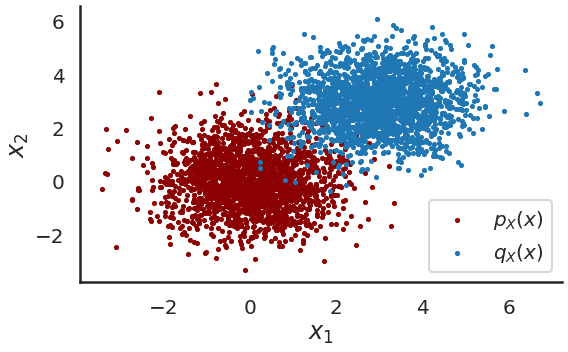

In [16]:
plt.figure(figsize=(8,5))
plt.scatter(px[:,0], px[:,1], label=r'$p_X(x)$', s=10, color='darkred')
plt.scatter(qx[:,0], qx[:,1], label=r'$q_X(x)$', s=10, color='tab:blue')

plt.legend(loc='lower right', fontsize=20)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
sns.despine()

In [17]:
true_xs = torch.cat([px, qx])
true_xs.shape

torch.Size([4000, 2])

In [19]:
true_ratios = torch.exp((q.log_prob(true_xs).sum(-1) - p.log_prob(true_xs).sum(-1)))
true_log_r = torch.log(true_ratios)

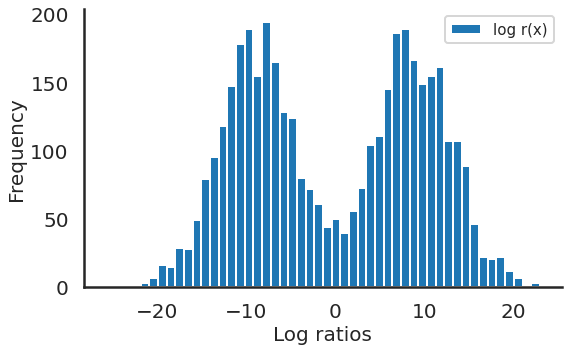

In [65]:
plt.figure(figsize=(8,5))
_ = plt.hist(true_log_r.data.cpu().numpy(), bins=50, label='log r(x)')
# plt.title('True log ratios')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)

plt.ylabel('Frequency', fontsize=20)
plt.xlabel('Log ratios', fontsize=20)
sns.despine()
plt.tight_layout()

------

# DRE Clf in X-Space

In [24]:
device = 'cuda'

In [25]:
def dict2namespace(config):
    namespace = argparse.Namespace()
    if isinstance(config, list):
        # from creating config files
        for i in range(len(config)):
            for key, value in config[i].items():
                if isinstance(value, dict):
                    new_value = dict2namespace(value)
                else:
                    new_value = value
                setattr(namespace, key, new_value)
    else:
        # vanilla training
        for key, value in config.items():
            if isinstance(value, dict):
                new_value = dict2namespace(value)
            else:
                new_value = value
            setattr(namespace, key, new_value)
    return namespace

In [27]:
with open(os.path.join('configs/classification/gmm/mlp_x.yaml'), 'r') as f:
    config = yaml.safe_load(f)
new_config = dict2namespace(config)

In [28]:
x_mlp = MLPClassifierv2(new_config)
restore_file = 'classification/results/gmm_clf_x/checkpoints/model_best.pth'
state = torch.load(restore_file, map_location='cuda')
x_mlp.load_state_dict(state['state_dict'])
x_mlp = x_mlp.to(device)

In [29]:
logits, probas = x_mlp(true_xs.cuda())
ratios = probas/(1-probas)
log_ratios = torch.log(ratios).squeeze()

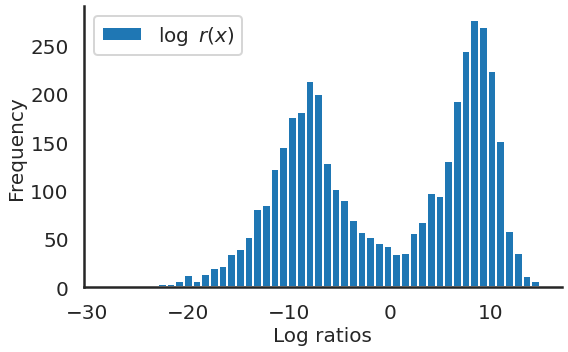

In [31]:
plt.figure(figsize=(8,5))
_ = plt.hist(log_ratios.data.cpu().numpy(), bins=50, label=r'$\log \ r(x)$')
# plt.title('Est. log ratios')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.legend(fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xlabel('Log ratios', fontsize=20)

sns.despine()
plt.tight_layout()

# Deeper DRE Clf in z-space (discriminative-only baseline)

x -> z = flow(x) -> clf(z)

In [32]:
with open(os.path.join('configs/classification/gmm/flow_mlp_z.yaml'), 'r') as f:
    config = yaml.safe_load(f)
new_config = dict2namespace(config)

In [33]:
flow_mlp = FlowClassifier(new_config)
restore_file = 'classification/results/gmm_flow_mlp_z/checkpoints/model_best.pth'
state = torch.load(restore_file, map_location='cuda')
flow_mlp.load_state_dict(state['state_dict'])
flow_mlp = flow_mlp.to(device)

In [34]:
# get dres
logits, probas = flow_mlp(true_xs.cuda())
ratios = probas/(1-probas)
flow_log_ratios = torch.log(ratios).squeeze()

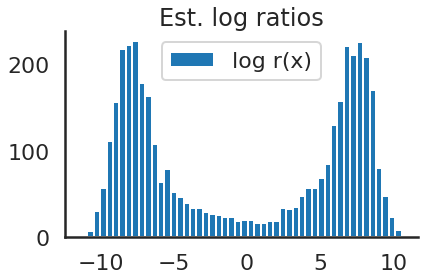

In [36]:
_ = plt.hist(flow_log_ratios.data.cpu().numpy(), bins=50, label='log r(x)')
plt.title('Est. log ratios')

plt.legend()
sns.despine()
plt.tight_layout()

# Z-Space

In [40]:
device = 'cuda'

In [37]:
with open(os.path.join('configs/classification/gmm/mlp_z.yaml'), 'r') as f:
    config = yaml.safe_load(f)
new_config = dict2namespace(config)

In [38]:
z_mlp = MLPClassifierv2(new_config)
restore_file = 'classification/results/gmm_z/checkpoints/model_best.pth'
state = torch.load(restore_file, map_location='cuda')
z_mlp.load_state_dict(state['state_dict'])
z_mlp = z_mlp.to(device)

In [39]:
# load flow
import os
from flows.models.maf import MAF

model = MAF(5, 
            2, 
            100, 
            1, 
            None, 
            'relu', 
            'sequential', 
            batch_norm=True)
restore_file = 'flows/results/gmm_flow/'
state = torch.load(os.path.join(restore_file, "best_model_checkpoint.pt"), map_location='cuda')
model.load_state_dict(state['model_state'])
model = model.to(device)
model.eval()

MAF(
  (net): FlowSequential(
    (0): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      )
    )
    (1): BatchNorm()
    (2): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      )
    )
    (3): BatchNorm()
    (4): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      

In [42]:
# get dres
z, _ = model.forward(true_xs.cuda())
logits, probas = z_mlp(z.cuda())
z_log_ratios = (logsumexp_1p(-logits) - logsumexp_1p(logits)).squeeze()

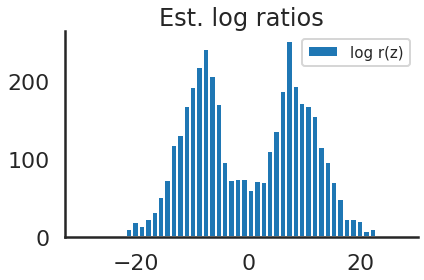

In [47]:
_ = plt.hist(z_log_ratios.data.cpu().numpy(), bins=50, label='log r(z)')
plt.title('Est. log ratios')

plt.legend(fontsize=15)
sns.despine()
plt.tight_layout()

--------

# Jointly trained flow classifier

In [48]:
with open(os.path.join('configs/classification/gmm/joint_flow_mlp_z.yaml'), 'r') as f:
    config = yaml.safe_load(f)
new_config = dict2namespace(config)

In [49]:
joint_flow_mlp = FlowClassifier(new_config)
restore_file = 'classification/results/joint_mlp_z/checkpoints/model_best.pth'
state = torch.load(restore_file, map_location='cuda')
joint_flow_mlp.load_state_dict(state['state_dict'])
joint_flow_mlp = joint_flow_mlp.to(device)

In [50]:
# get dres
logits, probas = joint_flow_mlp(true_xs.cuda())
joint_flow_log_ratios = (logsumexp_1p(-logits) - logsumexp_1p(logits)).squeeze()

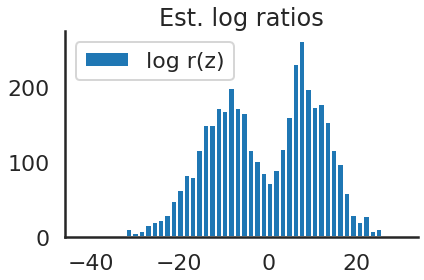

In [51]:
_ = plt.hist(joint_flow_log_ratios.data.cpu().numpy(), bins=50, label='log r(z)')
plt.title('Est. log ratios')

plt.legend()
sns.despine()
plt.tight_layout()

----

## Compare models

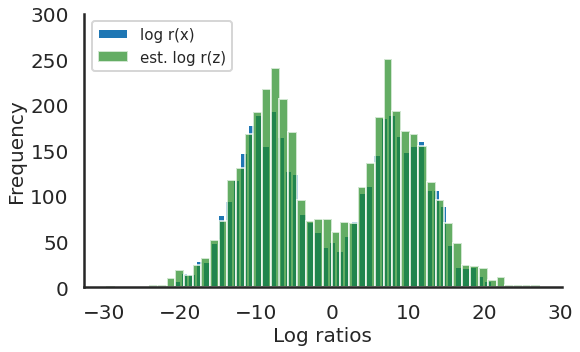

In [57]:
# z-space (ours) method vs. ground truth
plt.figure(figsize=(8,5))
_ = plt.hist(true_log_r.detach().data.cpu().numpy(), bins=50, label='log r(x)')
_ = plt.hist(z_log_ratios.data.cpu().numpy(), bins=50, label='est. log r(z)', alpha=0.7, color='forestgreen')
# plt.title('Log ratios in z-space')
plt.ylim(0, 300)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15, loc='upper left')

plt.ylabel('Frequency', fontsize=20)
plt.xlabel('Log ratios', fontsize=20)

sns.despine()
plt.tight_layout()

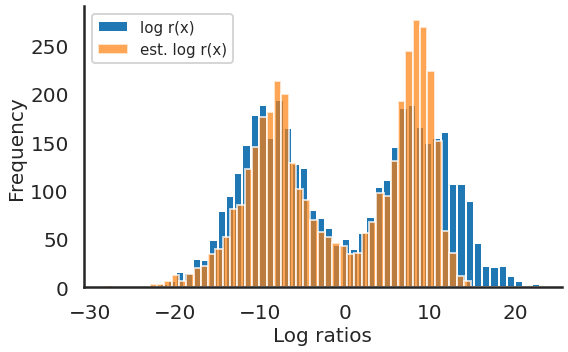

In [59]:
# x-space baseline vs. ground truth
plt.figure(figsize=(8,5))
_ = plt.hist(true_log_r.data.cpu().numpy(), bins=50, label='log r(x)')
_ = plt.hist(log_ratios.data.cpu().numpy(), bins=50, label='est. log r(x)', alpha=0.7)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.legend(fontsize=15, loc='upper left')

plt.ylabel('Frequency', fontsize=20)
plt.xlabel('Log ratios', fontsize=20)

sns.despine()
plt.tight_layout()

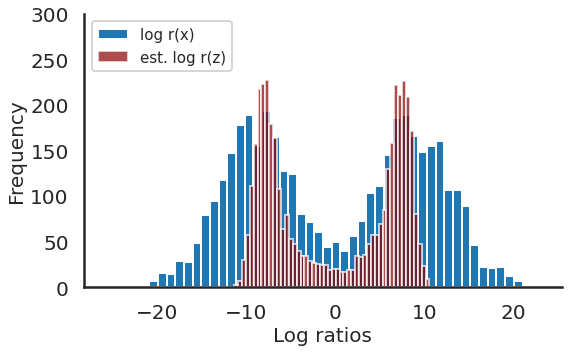

In [60]:
# discriminative training only vs. ground truth
plt.figure(figsize=(8,5))
_ = plt.hist(true_log_r.data.cpu().numpy(), bins=50, label='log r(x)')
_ = plt.hist(flow_log_ratios.data.cpu().numpy(), bins=50, label='est. log r(z)', alpha=0.7, color='darkred')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0,300)

plt.legend(fontsize=15, loc='upper left')
plt.ylabel('Frequency', fontsize=20)
plt.xlabel('Log ratios', fontsize=20)

sns.despine()
plt.tight_layout()

Text(0.5, 6.5, 'Log ratios')

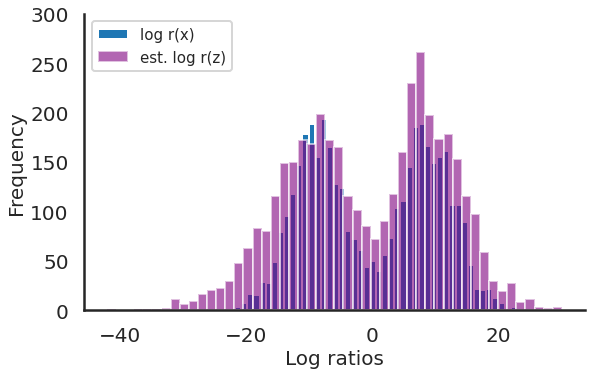

In [62]:
# joint training vs. ground truth
plt.figure(figsize=(8,5))
_ = plt.hist(true_log_r.data.cpu().numpy(), bins=50, label='log r(x)')
_ = plt.hist(joint_flow_log_ratios.data.cpu().numpy(), bins=50, label='est. log r(z)', alpha=0.6, color='purple')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0,300)

plt.legend(fontsize=15, loc='upper left')

sns.despine()
plt.tight_layout()

plt.ylabel('Frequency', fontsize=20)
plt.xlabel('Log ratios', fontsize=20)

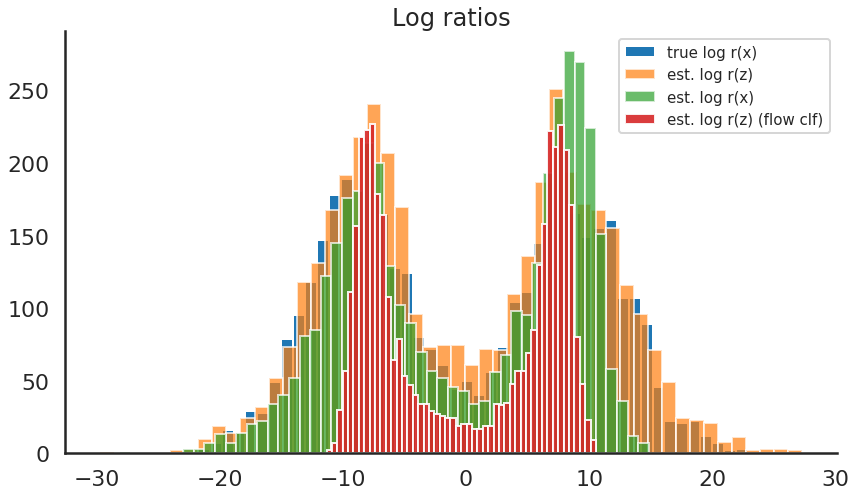

In [64]:
# all together

plt.figure(figsize=(12,7))
_ = plt.hist(true_log_r.data.cpu().numpy(), bins=50, label='true log r(x)')
_ = plt.hist(z_log_ratios.data.cpu().numpy(), bins=50, label='est. log r(z)', alpha=0.7)
_ = plt.hist(log_ratios.data.cpu().numpy(), bins=50, label='est. log r(x)', alpha=0.7)
_ = plt.hist(flow_log_ratios.data.cpu().numpy(), bins=50, label='est. log r(z) (flow clf)', alpha=0.9)
plt.title('Log ratios')

plt.legend(loc='upper right', fontsize=15)
sns.despine()
plt.tight_layout()